# Distributed data parallel MaskRCNN training with TensorFlow 2 and SageMaker

This notebook example shows how to use smdistributed.dataparallel with TensorFlow (version 2.4.1) on Amazon SageMaker to train a MaskRCNN model on COCO 2017 dataset using Amazon FSx for Lustre file-system as data source. Basically this notebook is using next original example code (Original source : https://github.com/aws/amazon-sagemaker-examples/blob/master/training/distributed_training/tensorflow/data_parallel/maskrcnn/tensorflow2_smdataparallel_maskrcnn_demo.ipynb) but some configuration and analytics codes were added for the workshop.


**NOTE :** This code is using SageMaker bring your own container algorithm concpet. For more information of this concept you can refer to this link : https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html


---
## STEP 1. Preparing dataset, pretrained model, and training script

For more efficient workshop, dataset and pretrainded model, algorithm iamge, etc. are ready to be run.  

_If you want to configure these resources manually, you can use CloudFormation template([`TF_DP_CFN.yaml`](TF_DP_CFN.yaml)) included._

Finalize the perepartion by nstall additional dependencies and check the resources.

In [71]:
!python3 -m pip install --upgrade sagemaker
!pip install pycocotools
!pip install smdebug

     |████████████████████████████████| 420 kB 45.9 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.48.1-py2.py3-none-any.whl size=590468 sha256=ab5444935dbcc4492d0932f8133515a331183bb6c1b4f7eec9e54edf22556b3f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/16/3f/df/2ad2bfd42c4ee903e27b045603175514134c036ac5ef134217
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.45.0
    Uninstalling sagemaker-2.45.0:
      Successfully uninstalled sagemaker-2.45.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 269 kB 39.0 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 2.7 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-us

### Checking dataset in s3

In your SageMaker default bucket, you can find coco-datset(https://cocodataset.org/) as tfrecord format. 

Files in your s3 will look like below:

```(bash)
# training images
<PATH>/train/train-00000-of-00256.tfrecord
             train-00001-of-00256.tfrecord
             train-00002-of-00256.tfrecord 
             ...
# pretrained model
<PATH>/model/resnet/resnet-nhwc-2018-02-07/checkpoint
                                           model.ckpt-112603.data-000...
                                           model.ckpt-112603.index
                                           model.ckpt-112603.meta
```

Here, `<PATH>` will be next format in S3
- s3://sagemaker-{region}-{your-account-id}/coco_dataset/

And it will be synched to `/opt/ml/input/data/train/` folder inside the SageMaker Tensorflow container later.

Let's check some of them with below code.

In [18]:
import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

!aws s3 ls s3://{bucket}/coco_dataset/train/ | head -5

2021-07-11 12:11:01   75763948 train-00000-of-00256.tfrecord
2021-07-11 12:11:01   76083838 train-00001-of-00256.tfrecord
2021-07-11 12:11:01   76832268 train-00002-of-00256.tfrecord
2021-07-11 12:11:01   77138520 train-00003-of-00256.tfrecord
2021-07-11 12:11:01   75993126 train-00004-of-00256.tfrecord

[Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='UTF-8'>
BrokenPipeError: [Errno 32] Broken pipe


### Checking FSx for Lustre 

Distributed training usually requires faster acess to training dataset. High-speed storage like **FSx for Lustre** is the best storage option for this requirement.

For the workshop, you already have FSx Lustre cluster connected to above s3 coco-dataset storage.  
Open [FSx for Lustre console](https://console.aws.amazon.com/fsx/) and check click the filesystem name

You can see the screen like below:

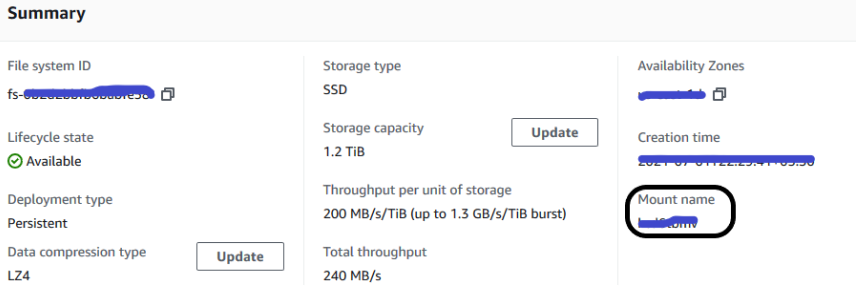

### TO DO: Remember the mount name and File system ID by updating nex cell.

In [40]:
fsx_mount_name = "<<your Mount name>>"     # will look like "cs3oxbmv"
file_system_id = "<<your File system ID>>" # will look like "fs-0657fe7d92a4c2345"

assert (fsx_mount_name !="<<your Mount name>>"), "Please update the mount name with yours"
assert (file_system_id !="<<your File system ID>>"), "Please update the File system ID with yours"

file_system_dns_name = "{}.us-east-1.amazonaws.com".format(file_system_id)

Below command will mount FSx filesystem to this notebook as a test. 

In [38]:
!sudo mkdir -p /fsx
!sudo mount -t lustre -o noatime,flock {file_system_dns_name}@tcp:/{fsx_mount_name} /fsx

Now you can see the filesystm connected to your S3 stroage with below cell command. 

(Actually we do not need to access thsi filesystem from this notebook since we will route training job to SageMaker environment. However, in your development project, you probabliy need to check the filesystem. For more information of accessing FSx Lustre filesystem, you can refer to this link: https://docs.aws.amazon.com/fsx/latest/LustreGuide/accessing-fs.html)


In [43]:
!ls -al /fsx/coco_dataset/

total 189
drwxr-xr-x 5 root root 25600 Jul 11 12:16 .
drwxr-xr-x 4 root root 33280 Jul 11 12:16 ..
drwxr-xr-x 2 root root 25600 Jul 11 12:16 annotations
drwxr-xr-x 4 root root 25600 Jul 11 12:16 model
drwxr-xr-x 2 root root 82944 Jul 11 12:16 train


### TO DO : Update "subnets", "security_group_ids" from the outputs of the CloudFormation as below

Similar to the file system information, VPC information for accessing FSx will be used when training later. 

Open the [CloudFormation console](https://console.aws.amazon.com/cloudformation) and click the stack. And move to Outputs tab and check the output of CloudFormation and update the two values. (subnet and security group)

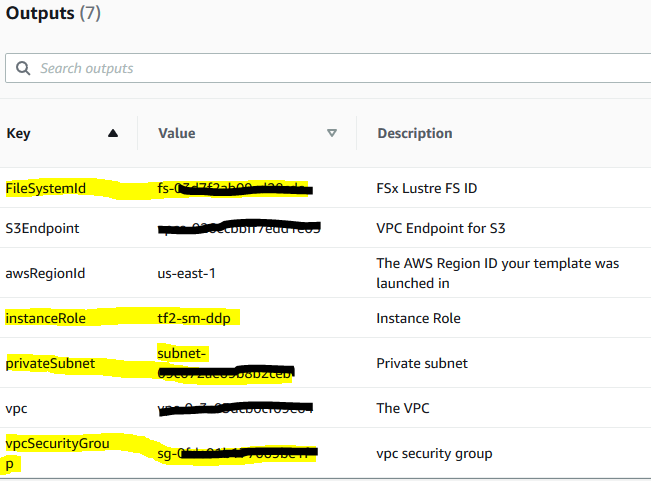

In [59]:
subnet_id = "<<your subnet>>"                 # will look like "subnet-0c961835de0f9a801"
security_group_id = "<<your security group>>" # will look like "sg-0999ec95f8003d3e1"

assert (subnet_id != "<<your subnet>>" ), "Please update subnet id with yours"
assert (security_group_id != "<<your security group>>"), "Please update security group id with yours"



### Preparing SageMaker Training Image

SageMaker provides the latest [Amazon Deep Learning Container Images (DLC)](https://github.com/aws/deep-learning-containers/blob/master/available_images.md) TensorFlow training image. In this step, we use it as a base image and install additional dependencies required for training MaskRCNN model.


**Build and Push Docker Image to ECR**

For more efficient workshop, we pre-configured the training docker iamge in your notebook.

In [49]:
!docker rmi 774070234146.dkr.ecr.us-east-1.amazonaws.com/tf2-mask-rcnn-ddp2:latest

Untagged: 774070234146.dkr.ecr.us-east-1.amazonaws.com/tf2-mask-rcnn-ddp2:latest
Untagged: 774070234146.dkr.ecr.us-east-1.amazonaws.com/tf2-mask-rcnn-ddp2@sha256:11a018ffa00929168479aff4321000a38d48ef002fe1f7e7fd935fcf3b5961c3


In [50]:
!docker images

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
tf2-mask-rcnn-ddp2   latest              0977980c7828        13 hours ago        9.2GB


Use this docker iamge and push it to your ECR with below command. **(It will take around 5~10 minutes.)**

In [51]:
%%sh

REGION=$(aws configure get region)
IMAGE_NAME="tf2-mask-rcnn-ddp2"  
TAG="latest"  

chmod +x build_and_push.sh; bash build_and_push.sh $REGION $IMAGE_NAME $TAG

creating ECR repository : 774070234146.dkr.ecr.us-east-1.amazonaws.com/tf2-mask-rcnn-ddp2:latest 
Login Succeeded
Login Succeeded
The push refers to repository [774070234146.dkr.ecr.us-east-1.amazonaws.com/tf2-mask-rcnn-ddp2]
92b5c7ac03c7: Preparing
342bcfd427dc: Preparing
6ba61c566abc: Preparing
f14967dc4bde: Preparing
7220541afc5b: Preparing
164f5f71f1c9: Preparing
6fba17d615b8: Preparing
0c571e9ec35a: Preparing
832fc832c708: Preparing
a3906ac790ce: Preparing
d291b5a945df: Preparing
50f011630c0d: Preparing
c70a058ee7ba: Preparing
a7259da5002e: Preparing
7c8f02f93d58: Preparing
7e2231187621: Preparing
369d9c231a31: Preparing
3adb2de9400d: Preparing
0e5d5be1e937: Preparing
d398818901e8: Preparing
0372c78f7b49: Preparing
ec4947f8a501: Preparing
c807e850fcc0: Preparing
748ca8a08284: Preparing
e704f02748b2: Preparing
1278e298a3b0: Preparing
95296bef6ec7: Preparing
722c6c870142: Preparing
1d5df340ddf6: Preparing
b54b8ac06fec: Preparing
f5b8f5766a25: Preparing
53194dce1444: Preparing
ef8330

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



**NOTE :** If you want to configure this image manually, you can build it with this [Dockerfile](Dockerfile) included.

In [ ]:
# !pygmentize ./Dockerfile

In [ ]:
# !pygmentize ./build_and_push.sh

### Preparing training script

In the Github repository https://github.com/HerringForks/DeepLearningExamples.git we have made `smdistributed.dataparallel` TensorFlow  MaskRCNN training script available for your use. We will be installing the same on the training image.

In [ ]:
rm -rf DeepLearningExamples
git clone --recursive https://github.com/HerringForks/DeepLearningExamples.git


---

## STEP 2. Amazon SageMaker Estimator using data parallel

Now we have all resource to run our experiment. Let's start training job.

### Amazon SageMaker Initialization

In [55]:
from sagemaker import get_execution_role
import boto3

role = get_execution_role()   # provide a pre-existing role ARN as an alternative to creating a new role
print(f"SageMaker Execution Role:{role}")

client = boto3.client("sts")
account = client.get_caller_identity()["Account"]
print(f"AWS account:{account}")

session = boto3.session.Session()
region = session.region_name
print(f"AWS region:{region}")

SageMaker Execution Role:arn:aws:iam::774070234146:role/tf2-sm-ddp
AWS account:774070234146
AWS region:us-east-1


To verify that the role above has required permissions:

1. Go to the IAM console: https://console.aws.amazon.com/iam/home.
2. Select **Roles**.
3. Enter the role name in the search box to search for that role. 
4. Select the role.
5. Use the **Permissions** tab to verify this role has required permissions attached.

### Defining SageMaker TensorFlow Estimator 



In the following code block, you can update the estimator function to use a different instance type, instance count, and distrubtion strategy. You're also passing in the training script you reviewed in the previous cell.

**Instance types**

`smdistributed.dataparallel` supports model training on SageMaker with the following instance types only. For best performance, it is recommended you use an instance type that supports Amazon Elastic Fabric Adapter (ml.p3dn.24xlarge and ml.p4d.24xlarge).

1. ml.p3.16xlarge
1. ml.p3dn.24xlarge [Recommended]
1. ml.p4d.24xlarge [Recommended]

**Instance count**

To get the best performance and the most out of `smdistributed.dataparallel`, you should use at least 2 instances, but you can also use 1 for testing this example.


In [60]:
image = "tf2-mask-rcnn-ddp2"  
tag = "latest"
instance_type = "ml.p3.16xlarge"   # Other supported instance type: ml.p3.16xlarge, ml.p4d.24xlarge ml.p3dn.24xlarge
instance_count = 2                 # You can use 2, 4, 8 etc.
docker_image = f"{account}.dkr.ecr.{region}.amazonaws.com/{image}:{tag}"  # YOUR_ECR_IMAGE_BUILT_WITH_ABOVE_DOCKER_FILE

subnets = [subnet_id]                      # Should be same as Subnet used for FSx. Example: subnet-0f9XXXX
security_group_ids = [security_group_id]   # Should be same as Security group used for FSx. sg-03ZZZZZZ

SM_DATA_ROOT = "/opt/ml/input/data/train"

hyperparameters = {
    "mode": "train",
    "checkpoint": "/".join([SM_DATA_ROOT, "model/resnet/resnet-nhwc-2018-02-07/model.ckpt-112603"]),
    "eval_samples": 5000,
    "init_learning_rate": 0.04,
    "learning_rate_steps": "3750,5000",
    "model_dir": "/opt/ml/code/checkpoints/tensorflow_mask_rcnn",
    "num_steps_per_eval": 462,
    "total_steps": 500,
    "train_batch_size": 4,
    "eval_batch_size": 8,
    "training_file_pattern": "/".join([SM_DATA_ROOT, "train"]),
    "validation_file_pattern": "/".join([SM_DATA_ROOT, "val"]),
    "val_json_file": "/".join([SM_DATA_ROOT, "annotations/instances_val2017.json"]),
    "amp": "",
    "use_batched_nms": "",
    "xla": "",
    "nouse_custom_box_proposals_op": "",
    "seed": 987,
}

**Set SageMaker Debugger Profiler**

You can monitor GPU resource consumption with SageMaker Debugger. Set a SageMaker ProfilerConfig to monitor training instace every 500 miliseconds with default configuration.


In [65]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile()
)

**Distribution strategy**

Note that to use DDP mode, you update the the `distribution` strategy, and set it to use `smdistributed dataparallel`.


In [66]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    entry_point="DeepLearningExamples/TensorFlow2/Segmentation/MaskRCNN/mask_rcnn_sm.py",
    role=role,
    image_uri=docker_image,
    source_dir=".",
    framework_version="2.4.1",
    py_version="py37",
    instance_count=instance_count,
    instance_type=instance_type,
    sagemaker_session=sagemaker_session,
    subnets=subnets,
    hyperparameters=hyperparameters,
    security_group_ids=security_group_ids,
    debugger_hook_config=False,
    # Training using smdistributed.dataparallel Distributed Training Framework
    distribution={"smdistributed": {"dataparallel": {"enabled": True, "custom_mpi_options": "-verbose -x NCCL_DEBUG=VERSION"}}},
    profiler_config=profiler_config,
)

### Run training job

Configure FSX input dataset and submit training job. **(Training will take 20~22 minutes.)**

In [67]:
# Configure FSx Input for your SageMaker Training job

from sagemaker.inputs import FileSystemInput
file_system_directory_path = "/"+fsx_mount_name+"/coco_dataset"   # NOTE: '/fsx/' will be the root mount path. Example: '/fsx/mask_rcnn/PyTorch' l4po7bmv
file_system_access_mode = "ro"
file_system_type = "FSxLustre"
train_fs = FileSystemInput(
    file_system_id=file_system_id,
    file_system_type=file_system_type,
    directory_path=file_system_directory_path,
    file_system_access_mode=file_system_access_mode,
)
data_channels = {"train": train_fs}

In [68]:
%%time
# Submit SageMaker training job
estimator.fit(inputs=data_channels, wait=False)

CPU times: user 3min 42s, sys: 23.7 s, total: 4min 6s
Wall time: 3min 42s


---
## STEP 3. Training script review

## Where to change the code (from document) (TBU)
https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html


To run Inside your training script, you need to add several codes to run
1. Import the library's TensorFlow client and initialize it:
    ```
    import smdistributed.dataparallel.tensorflow as sdp
    sdp.init()
    ```
1. Pin each GPU to a single smdistributed.dataparallel process with local_rank—this refers to the relative rank of the process within a given node. The sdp.tensorflow.local_rank() API provides you the local rank of the device. The leader node is rank 0, and the worker nodes are rank 1, 2, 3, and so on. This is invoked in the next code block as sdp.local_rank(). set_memory_growth is not directly related to SageMaker distributed, but must be set for distributed training with TensorFlow.
    ```
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        tf.config.experimental.set_visible_devices(gpus[sdp.local_rank()], 'GPU')
    ```
1. Scale the learning rate by the number of workers. The sdp.tensorflow.size() API provides you the number of workers in the cluster. This is invoked in the next code block as sdp.size().
```
learning_rate = learning_rate * sdp.size()
```
1. Use the library’s DistributedGradientTape  to optimize AllReduce operations during training. This wraps tf.GradientTape. 
    ```
    with tf.GradientTape() as tape:
          output = model(input)
          loss_value = loss(label, output)

    # SageMaker data parallel: Wrap tf.GradientTape with the library's DistributedGradientTape
    tape = sdp.DistributedGradientTape(tape)
    ```
1. Broadcast the initial model variables from the leader node (rank 0) to all the worker nodes (ranks 1 through n). This is needed to ensure a consistent initialization across all the worker ranks. For this, you use the sdp.tensorflow.broadcast_variables API after the model and optimizer variables are initialized. This is invoked in the next code block as sdp.broadcast_variables().
```
sdp.broadcast_variables(model.variables, root_rank=0)
sdp.broadcast_variables(opt.variables(), root_rank=0)
```
1. Finally, modify your script to save checkpoints only on the leader node. The leader node has a synchronized model. This also avoids worker nodes overwriting the checkpoints and possibly corrupting the checkpoints.
```
    if sdp.rank() == 0:
        checkpoint.save(checkpoint_dir)
```


## Our file structure (TBU)

From the entrypoint script `DeepLearningExamples/TensorFlow2/Segmentation/MaskRCNN/mask_rcnn_sm.py` that you defined above, let's look at the code to training job with SageMaker data parallel. This sample source code has below code structure.
- `mask_rcnn_sm.py` calls `mask_rcnn_main.py` with hyperparameters
- `mask_rcnn_main.py` uses `distributed_executer.EstimatorExecuter` object to run training job parallel and this class is defined in `DeepLearningExamples/TensorFlow2/Segmentation/MaskRCNN/mask_rcnn/distributed_executer.py` file.



Let's look at the `distributed_executer.py` code with below cell.

In [33]:
# !pygmentize DeepLearningExamples/TensorFlow2/Segmentation/MaskRCNN/mask_rcnn/distributed_executer.py

---
## STEP 4. Monitor training instances with SageMaker Debugger profiler

SageMaker Debugger profiler provide resource monitoring while training is running. Below code will check the profiling data is ready to track. 

In [69]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: tf2-mask-rcnn-ddp2-2021-07-11-14-38-10-964
Region: us-east-1


In [72]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()




[2021-07-11 14:43:02.656 ip-172-16-62-191:21337 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-774070234146/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 7, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 5, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 13, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 9, "NumSteps": 3, "ProfilerName": "cprofile", "cProfileTimer": "default", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 15, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-774070234146/tf2-mask-rcnn-ddp2-2021-07-11-14-38-10-964/profiler-output
Profiler data from system not available yet
time: 1626014583.8330638 TrainingJobStatus:InProgress TrainingJobSecondaryStatus:Starting
Profiler data from system not available yet
Profiler data from s

In [73]:
# Get the metrics reader and refresh it
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()


## Plotting Metrics

Wile running training job, training job will create resource profile and Debugger job will collect this metric. You can monitor whether the resources are utilized properly for our training job with below visualization tools. You can continue to monitor it in the middle and later

### System metrics histogram

In [81]:
from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram

metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["CPU", "I/O"],
    select_events=["total"]
)

[2021-07-11 14:53:13.709 ip-172-16-62-191:21337 INFO metrics_reader_base.py:134] Getting 10 event files
Found 33778 system metrics events from timestamp_in_us:0 to timestamp_in_us:1626014760000000
select events:['total']
select dimensions:['CPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'I/OWaitPercentage-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-2', 'CPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-2'}


filtered_dimensions:{'I/OWaitPercentage-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-2', 'CPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-2'}


In [82]:
metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["GPU"],
    select_events=["total"]
)

[2021-07-11 14:53:31.832 ip-172-16-62-191:21337 INFO metrics_reader_base.py:134] Getting 16 event files
Found 252634 system metrics events from timestamp_in_us:0 to timestamp_in_us:1626015120000000
select events:['total']
select dimensions:['GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-2', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-2'}


filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-2', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-2'}


In [75]:
metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["GPU"],
    select_events=["total"]
)

[2021-07-11 14:47:18.173 ip-172-16-62-191:21337 INFO metrics_reader_base.py:134] Getting 4 event files
Found 33778 system metrics events from timestamp_in_us:0 to timestamp_in_us:1626014760000000
select events:['total']
select dimensions:['GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-2', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-2'}


filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-2', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-2'}


### System and framework metrics heatmap

In [83]:
from smdebug.profiler.analysis.notebook_utils.heatmap import Heatmap

view_heatmap = Heatmap(
    system_metrics_reader,
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"],
    plot_height=400
)

[2021-07-11 14:54:31.518 ip-172-16-62-191:21337 INFO metrics_reader_base.py:134] Getting 18 event files
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization', 'I/OWaitPercentage', 'CPUUtilization', 'GPUMemoryUtilization'}


### Time line charts

In [84]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2021-07-11 14:54:45.016 ip-172-16-62-191:21337 INFO metrics_reader_base.py:134] Getting 18 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-2', 'GPUUtilization-nodeid:algo-2', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-2'}


### Checking final result

The final report is created after the job is finished, so wait for the job to finish. 

You can connect to the training job again by changing asynchronous mode (wait=False) to synchronous mode (wait=True) with next command. 

In [85]:
sagemaker.Session().logs_for_job(job_name=training_job_name, wait=True)

2021-07-11 14:57:23 Starting - Preparing the instances for training
2021-07-11 14:57:23 Downloading - Downloading input data
2021-07-11 14:57:23 Training - Training image download completed. Training in progress.2021-07-11 14:48:45.039818: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-07-11 14:48:45.049326: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 1
2021-07-11 14:48:45.050247: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2021-07-11 14:48:45.050277: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:122] Base Folder : /opt/ml/output/profiler
2021-07-11 14:48:45.050301: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:123] Node Id : 1-algo-2
2021-07-11 14:48:45.050308: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:124] Maximum 

In [86]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-774070234146/tf2-mask-rcnn-ddp2-2021-07-11-14-38-10-964/rule-output


In [87]:
!aws s3 cp {rule_output_path} . --recursive

download: s3://sagemaker-us-east-1-774070234146/tf2-mask-rcnn-ddp2-2021-07-11-14-38-10-964/rule-output/ProfilerReport-1626014290/profiler-output/profiler-report.html to ProfilerReport-1626014290/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-774070234146/tf2-mask-rcnn-ddp2-2021-07-11-14-38-10-964/rule-output/ProfilerReport-1626014290/profiler-output/profiler-reports/BatchSize.json to ProfilerReport-1626014290/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-774070234146/tf2-mask-rcnn-ddp2-2021-07-11-14-38-10-964/rule-output/ProfilerReport-1626014290/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport-1626014290/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-774070234146/tf2-mask-rcnn-ddp2-2021-07-11-14-38-10-964/rule-output/ProfilerReport-1626014290/profiler-output/profiler-report.ipynb to ProfilerReport-1626014290/profiler-output/profiler-report.ipynb
do

### Explore the report from Debugger Profiler

Check the downloaded `profiler-report.hmtl` file.  
(You need to click `Trust HTML` buttom on left top coner of new HTML tab in the Jupyter Lab.)

For more information about profiling report here: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-profiling-report.html


In [88]:
from IPython.display import FileLink
import glob
report_folder = glob.glob("Profiler*")[0]
display("Click link below to view the profiler report", FileLink(report_folder + "/profiler-output/profiler-report.html"))

'Click link below to view the profiler report'

/home/ec2-user/SageMaker/tf-ddp-workshop/ProfilerReport-1626014290/profiler-output/profiler-report.html

---
# Additional Resources

If you are a new user of Amazon SageMaker, you may find the following helpful to understand how SageMaker uses Docker to train custom models.
* To learn more about using Amazon SageMaker with your own training image, see [Use Your Own Training Algorithms
](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html).

* To learn more about using Docker to train your own models with Amazon SageMaker, see [Example Notebooks: Use Your Own Algorithm or Model](https://docs.aws.amazon.com/sagemaker/latest/dg/adv-bring-own-examples.html).
* To see other examples of distributed training using Amazon SageMaker and TensorFlow, see [Distributed TensorFlow training using Amazon SageMaker
](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/distributed_tensorflow_mask_rcnn).